<a href="https://colab.research.google.com/github/aribamazharam/efficient-net/blob/main/Yoga_EfficientNet_b0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!pip install efficientnet_pytorch
!pip install torch torchvision

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=bed28c2fde8c1da95ac0668b48261da30ad4aac1127dabaabd18ac9bb4d50ad9
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [9]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from efficientnet_pytorch import EfficientNet

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
import os
from torchvision import datasets, transforms
import torch

# Path to your data
data_dir = '/content/drive/MyDrive/YogaPose/new_dataset'  # Replace with your dataset directory
train_dir = os.path.join(data_dir, 'train')  # Assuming you have a train directory
val_dir = os.path.join(data_dir, 'valid')  # Assuming you have a validation directory

# Define transformations for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomResizedCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

val_transforms = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
val_data = datasets.ImageFolder(val_dir, transform=val_transforms)
test_data = datasets.ImageFolder(val_dir, transform=test_transforms)

# Create dataloaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(val_data, batch_size=64)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

In [16]:
num_classes = len(train_data.classes)  # Assuming each folder in your directory is a different class

# Load pre-trained model
model = EfficientNet.from_pretrained('efficientnet-b0')

# Adjust last layer to match number of classes
num_ftrs = model._fc.in_features
model._fc = nn.Linear(num_ftrs, num_classes)

# Move to gpu and parallelize
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

Loaded pretrained weights for efficientnet-b0


In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [18]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 728.8/728.8 kB 13.5 MB/s eta 0:00:00


In [25]:
from efficientnet_pytorch import EfficientNet
import torch.optim as optim
import torch.nn as nn
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Define the device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Initialize the model
model_name = 'efficientnet-b0'
model = EfficientNet.from_pretrained(model_name, num_classes=num_classes) # `num_classes` should be the number of classes in your data.
model = model.to(device)

# Define the criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

EPOCHS = 50
best_val_loss = float('inf')  # initialize best validation loss

# Training loop
model.train()
for epoch in range(EPOCHS):
    running_loss = 0.0
    all_preds = []
    all_labels = []
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        # Add batch predictions and labels to lists
        all_preds += preds.detach().cpu().numpy().tolist()
        all_labels += labels.detach().cpu().numpy().tolist()

    # Compute validation loss and metrics
    val_loss = 0.0
    val_all_preds = []
    val_all_labels = []
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for inputs, labels in valloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)

            # Add batch predictions and labels to lists
            val_all_preds += preds.detach().cpu().numpy().tolist()
            val_all_labels += labels.detach().cpu().numpy().tolist()

    model.train()  # set model back to training mode
    epoch_loss = running_loss / len(trainloader.dataset)
    val_loss = val_loss / len(valloader.dataset)

    # Save model if validation loss has decreased
    if val_loss <= best_val_loss:
        print(f'Validation loss decreased ({best_val_loss:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), '/content/drive/MyDrive/YogaPose/model_checkpoints/model.pt')
        best_val_loss = val_loss

    # Calculate and print metrics
    train_acc = accuracy_score(all_labels, all_preds)
    train_prec = precision_score(all_labels, all_preds, average='macro')
    train_recall = recall_score(all_labels, all_preds, average='macro')
    val_acc = accuracy_score(val_all_labels, val_all_preds)
    val_prec = precision_score(val_all_labels, val_all_preds, average='macro')
    val_recall = recall_score(val_all_labels, val_all_preds, average='macro')

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print(f'Training Loss: {epoch_loss:.4f}, Accuracy: {train_acc:.4f}, Precision: {train_prec:.4f}, Recall: {train_recall:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}, Precision: {val_prec:.4f}, Recall: {val_recall:.4f}\n')


Loaded pretrained weights for efficientnet-b0
Validation loss decreased (inf --> 4.625036).  Saving model ...
Epoch 1/50
Training Loss: 4.6436, Accuracy: 0.0132, Precision: 0.0140, Recall: 0.0133
Validation Loss: 4.6250, Accuracy: 0.0113, Precision: 0.0135, Recall: 0.0110



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (4.625036 --> 4.578421).  Saving model ...
Epoch 2/50
Training Loss: 4.6024, Accuracy: 0.0203, Precision: 0.0182, Recall: 0.0184
Validation Loss: 4.5784, Accuracy: 0.0227, Precision: 0.0148, Recall: 0.0195



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (4.578421 --> 4.532851).  Saving model ...
Epoch 3/50
Training Loss: 4.5632, Accuracy: 0.0326, Precision: 0.0297, Recall: 0.0281
Validation Loss: 4.5329, Accuracy: 0.0435, Precision: 0.0278, Recall: 0.0370



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (4.532851 --> 4.486314).  Saving model ...
Epoch 4/50
Training Loss: 4.5242, Accuracy: 0.0496, Precision: 0.0358, Recall: 0.0400
Validation Loss: 4.4863, Accuracy: 0.0624, Precision: 0.0482, Recall: 0.0509



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (4.486314 --> 4.443155).  Saving model ...
Epoch 5/50
Training Loss: 4.4885, Accuracy: 0.0584, Precision: 0.0456, Recall: 0.0470
Validation Loss: 4.4432, Accuracy: 0.0813, Precision: 0.0576, Recall: 0.0649



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (4.443155 --> 4.401509).  Saving model ...
Epoch 6/50
Training Loss: 4.4486, Accuracy: 0.0765, Precision: 0.0618, Recall: 0.0612
Validation Loss: 4.4015, Accuracy: 0.0983, Precision: 0.0847, Recall: 0.0791



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (4.401509 --> 4.336791).  Saving model ...
Epoch 7/50
Training Loss: 4.4055, Accuracy: 0.0972, Precision: 0.0748, Recall: 0.0757
Validation Loss: 4.3368, Accuracy: 0.1191, Precision: 0.0847, Recall: 0.0911



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (4.336791 --> 4.277401).  Saving model ...
Epoch 8/50
Training Loss: 4.3611, Accuracy: 0.1032, Precision: 0.0756, Recall: 0.0799
Validation Loss: 4.2774, Accuracy: 0.1418, Precision: 0.1138, Recall: 0.1097



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (4.277401 --> 4.209652).  Saving model ...
Epoch 9/50
Training Loss: 4.3096, Accuracy: 0.1244, Precision: 0.1006, Recall: 0.0973
Validation Loss: 4.2097, Accuracy: 0.1493, Precision: 0.1185, Recall: 0.1156



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (4.209652 --> 4.141194).  Saving model ...
Epoch 10/50
Training Loss: 4.2530, Accuracy: 0.1301, Precision: 0.1179, Recall: 0.1018
Validation Loss: 4.1412, Accuracy: 0.1682, Precision: 0.1247, Recall: 0.1299



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (4.141194 --> 4.052853).  Saving model ...
Epoch 11/50
Training Loss: 4.2003, Accuracy: 0.1416, Precision: 0.1183, Recall: 0.1109
Validation Loss: 4.0529, Accuracy: 0.1701, Precision: 0.1431, Recall: 0.1329



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (4.052853 --> 3.962253).  Saving model ...
Epoch 12/50
Training Loss: 4.1339, Accuracy: 0.1526, Precision: 0.1291, Recall: 0.1197
Validation Loss: 3.9623, Accuracy: 0.1947, Precision: 0.1616, Recall: 0.1506



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (3.962253 --> 3.852433).  Saving model ...
Epoch 13/50
Training Loss: 4.0586, Accuracy: 0.1718, Precision: 0.1527, Recall: 0.1366
Validation Loss: 3.8524, Accuracy: 0.2287, Precision: 0.1802, Recall: 0.1812



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (3.852433 --> 3.746533).  Saving model ...
Epoch 14/50
Training Loss: 3.9793, Accuracy: 0.1837, Precision: 0.1941, Recall: 0.1481
Validation Loss: 3.7465, Accuracy: 0.2476, Precision: 0.1844, Recall: 0.1985



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (3.746533 --> 3.670746).  Saving model ...
Epoch 15/50
Training Loss: 3.8986, Accuracy: 0.2009, Precision: 0.1927, Recall: 0.1619
Validation Loss: 3.6707, Accuracy: 0.2571, Precision: 0.1814, Recall: 0.2049



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (3.670746 --> 3.514881).  Saving model ...
Epoch 16/50
Training Loss: 3.8207, Accuracy: 0.2095, Precision: 0.2208, Recall: 0.1697
Validation Loss: 3.5149, Accuracy: 0.2873, Precision: 0.2088, Recall: 0.2326



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (3.514881 --> 3.414918).  Saving model ...
Epoch 17/50
Training Loss: 3.7401, Accuracy: 0.2221, Precision: 0.2264, Recall: 0.1817
Validation Loss: 3.4149, Accuracy: 0.2911, Precision: 0.2010, Recall: 0.2351



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (3.414918 --> 3.294590).  Saving model ...
Epoch 18/50
Training Loss: 3.6440, Accuracy: 0.2393, Precision: 0.2406, Recall: 0.1978
Validation Loss: 3.2946, Accuracy: 0.3081, Precision: 0.1907, Recall: 0.2502



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (3.294590 --> 3.191346).  Saving model ...
Epoch 19/50
Training Loss: 3.5632, Accuracy: 0.2479, Precision: 0.2332, Recall: 0.2062
Validation Loss: 3.1913, Accuracy: 0.3100, Precision: 0.2042, Recall: 0.2522



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (3.191346 --> 3.082869).  Saving model ...
Epoch 20/50
Training Loss: 3.4936, Accuracy: 0.2520, Precision: 0.2717, Recall: 0.2112
Validation Loss: 3.0829, Accuracy: 0.3176, Precision: 0.2116, Recall: 0.2607



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (3.082869 --> 2.986711).  Saving model ...
Epoch 21/50
Training Loss: 3.3972, Accuracy: 0.2741, Precision: 0.2741, Recall: 0.2307
Validation Loss: 2.9867, Accuracy: 0.3497, Precision: 0.2421, Recall: 0.2907



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (2.986711 --> 2.909970).  Saving model ...
Epoch 22/50
Training Loss: 3.3225, Accuracy: 0.2741, Precision: 0.2859, Recall: 0.2330
Validation Loss: 2.9100, Accuracy: 0.3629, Precision: 0.2489, Recall: 0.3015



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (2.909970 --> 2.836339).  Saving model ...
Epoch 23/50
Training Loss: 3.2484, Accuracy: 0.2933, Precision: 0.3116, Recall: 0.2507
Validation Loss: 2.8363, Accuracy: 0.3629, Precision: 0.2545, Recall: 0.3009



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (2.836339 --> 2.726322).  Saving model ...
Epoch 24/50
Training Loss: 3.1789, Accuracy: 0.2937, Precision: 0.3401, Recall: 0.2519
Validation Loss: 2.7263, Accuracy: 0.3705, Precision: 0.2709, Recall: 0.3096



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (2.726322 --> 2.642731).  Saving model ...
Epoch 25/50
Training Loss: 3.1271, Accuracy: 0.3006, Precision: 0.3107, Recall: 0.2602
Validation Loss: 2.6427, Accuracy: 0.3932, Precision: 0.3041, Recall: 0.3331



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (2.642731 --> 2.571239).  Saving model ...
Epoch 26/50
Training Loss: 3.0369, Accuracy: 0.3314, Precision: 0.3649, Recall: 0.2884
Validation Loss: 2.5712, Accuracy: 0.4008, Precision: 0.3226, Recall: 0.3433



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (2.571239 --> 2.513289).  Saving model ...
Epoch 27/50
Training Loss: 2.9885, Accuracy: 0.3248, Precision: 0.3630, Recall: 0.2832
Validation Loss: 2.5133, Accuracy: 0.4083, Precision: 0.3286, Recall: 0.3493



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (2.513289 --> 2.431216).  Saving model ...
Epoch 28/50
Training Loss: 2.9363, Accuracy: 0.3396, Precision: 0.3858, Recall: 0.2982
Validation Loss: 2.4312, Accuracy: 0.4159, Precision: 0.3355, Recall: 0.3593



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (2.431216 --> 2.399343).  Saving model ...
Epoch 29/50
Training Loss: 2.8717, Accuracy: 0.3376, Precision: 0.3577, Recall: 0.2953
Validation Loss: 2.3993, Accuracy: 0.4234, Precision: 0.3378, Recall: 0.3651



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (2.399343 --> 2.320746).  Saving model ...
Epoch 30/50
Training Loss: 2.8201, Accuracy: 0.3581, Precision: 0.4087, Recall: 0.3181
Validation Loss: 2.3207, Accuracy: 0.4405, Precision: 0.3664, Recall: 0.3824



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (2.320746 --> 2.273647).  Saving model ...
Epoch 31/50
Training Loss: 2.7622, Accuracy: 0.3647, Precision: 0.4031, Recall: 0.3243
Validation Loss: 2.2736, Accuracy: 0.4518, Precision: 0.3660, Recall: 0.3941



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (2.273647 --> 2.216911).  Saving model ...
Epoch 32/50
Training Loss: 2.7015, Accuracy: 0.3746, Precision: 0.3953, Recall: 0.3369
Validation Loss: 2.2169, Accuracy: 0.4612, Precision: 0.3811, Recall: 0.4053



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (2.216911 --> 2.186392).  Saving model ...
Epoch 33/50
Training Loss: 2.6594, Accuracy: 0.3843, Precision: 0.3772, Recall: 0.3467
Validation Loss: 2.1864, Accuracy: 0.4575, Precision: 0.3704, Recall: 0.4030



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (2.186392 --> 2.127174).  Saving model ...
Epoch 34/50
Training Loss: 2.6146, Accuracy: 0.3958, Precision: 0.4399, Recall: 0.3597
Validation Loss: 2.1272, Accuracy: 0.4631, Precision: 0.3632, Recall: 0.4080



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (2.127174 --> 2.091414).  Saving model ...
Epoch 35/50
Training Loss: 2.5693, Accuracy: 0.4046, Precision: 0.4307, Recall: 0.3672
Validation Loss: 2.0914, Accuracy: 0.4612, Precision: 0.3742, Recall: 0.4082



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (2.091414 --> 2.055118).  Saving model ...
Epoch 36/50
Training Loss: 2.5063, Accuracy: 0.4095, Precision: 0.4412, Recall: 0.3726
Validation Loss: 2.0551, Accuracy: 0.4764, Precision: 0.4065, Recall: 0.4221



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (2.055118 --> 2.013546).  Saving model ...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 37/50
Training Loss: 2.4765, Accuracy: 0.4194, Precision: 0.4435, Recall: 0.3845
Validation Loss: 2.0135, Accuracy: 0.4820, Precision: 0.4190, Recall: 0.4319



/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (2.013546 --> 1.972660).  Saving model ...
Epoch 38/50
Training Loss: 2.4315, Accuracy: 0.4225, Precision: 0.4450, Recall: 0.3853
Validation Loss: 1.9727, Accuracy: 0.4953, Precision: 0.4505, Recall: 0.4485



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (1.972660 --> 1.942491).  Saving model ...
Epoch 39/50
Training Loss: 2.4048, Accuracy: 0.4198, Precision: 0.4546, Recall: 0.3868
Validation Loss: 1.9425, Accuracy: 0.4972, Precision: 0.4623, Recall: 0.4494



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (1.942491 --> 1.905681).  Saving model ...
Epoch 40/50
Training Loss: 2.3754, Accuracy: 0.4355, Precision: 0.4595, Recall: 0.4000
Validation Loss: 1.9057, Accuracy: 0.5161, Precision: 0.4760, Recall: 0.4676



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (1.905681 --> 1.879133).  Saving model ...
Epoch 41/50
Training Loss: 2.3498, Accuracy: 0.4417, Precision: 0.4627, Recall: 0.4091
Validation Loss: 1.8791, Accuracy: 0.5009, Precision: 0.4560, Recall: 0.4561



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (1.879133 --> 1.840850).  Saving model ...
Epoch 42/50
Training Loss: 2.3091, Accuracy: 0.4505, Precision: 0.4791, Recall: 0.4179
Validation Loss: 1.8409, Accuracy: 0.5123, Precision: 0.4740, Recall: 0.4660



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (1.840850 --> 1.815160).  Saving model ...
Epoch 43/50
Training Loss: 2.2752, Accuracy: 0.4545, Precision: 0.4832, Recall: 0.4221
Validation Loss: 1.8152, Accuracy: 0.5255, Precision: 0.4809, Recall: 0.4829



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (1.815160 --> 1.796467).  Saving model ...
Epoch 44/50
Training Loss: 2.2367, Accuracy: 0.4631, Precision: 0.4757, Recall: 0.4299
Validation Loss: 1.7965, Accuracy: 0.5217, Precision: 0.5023, Recall: 0.4810



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (1.796467 --> 1.777094).  Saving model ...
Epoch 45/50
Training Loss: 2.1958, Accuracy: 0.4673, Precision: 0.4774, Recall: 0.4328
Validation Loss: 1.7771, Accuracy: 0.5350, Precision: 0.5162, Recall: 0.4923



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (1.777094 --> 1.754000).  Saving model ...
Epoch 46/50
Training Loss: 2.1639, Accuracy: 0.4785, Precision: 0.5008, Recall: 0.4487
Validation Loss: 1.7540, Accuracy: 0.5293, Precision: 0.5018, Recall: 0.4895



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (1.754000 --> 1.742082).  Saving model ...
Epoch 47/50
Training Loss: 2.1582, Accuracy: 0.4719, Precision: 0.4866, Recall: 0.4430
Validation Loss: 1.7421, Accuracy: 0.5425, Precision: 0.5277, Recall: 0.5021



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (1.742082 --> 1.707077).  Saving model ...
Epoch 48/50
Training Loss: 2.1252, Accuracy: 0.4792, Precision: 0.4862, Recall: 0.4494
Validation Loss: 1.7071, Accuracy: 0.5369, Precision: 0.5039, Recall: 0.4972



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (1.707077 --> 1.679109).  Saving model ...
Epoch 49/50
Training Loss: 2.0756, Accuracy: 0.4957, Precision: 0.5056, Recall: 0.4659
Validation Loss: 1.6791, Accuracy: 0.5463, Precision: 0.5102, Recall: 0.5062



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation loss decreased (1.679109 --> 1.653549).  Saving model ...
Epoch 50/50
Training Loss: 2.0638, Accuracy: 0.4897, Precision: 0.4968, Recall: 0.4580
Validation Loss: 1.6535, Accuracy: 0.5595, Precision: 0.5380, Recall: 0.5229



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for effi

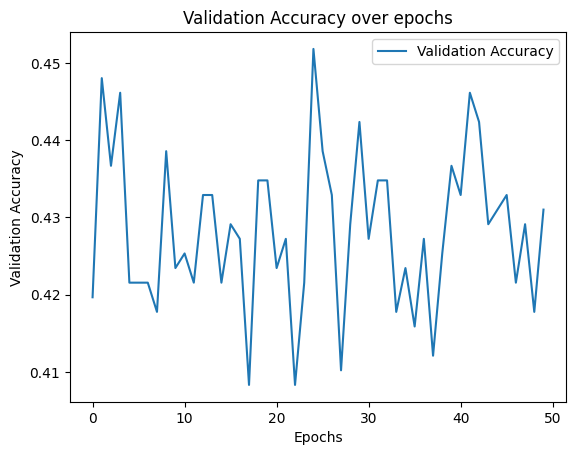

In [39]:
import matplotlib.pyplot as plt
import torch

# Define your validation function
def evaluate_model(model, valloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

# Define where your model checkpoints are saved
checkpoint_dir = "/content/drive/MyDrive/YogaPose/model_checkpoints/"

val_accuracies = []

for epoch in range(EPOCHS):
    checkpoint_path = f"{checkpoint_dir}model.pt"

    # Load the model checkpoint
    model = EfficientNet.from_pretrained(model_name, num_classes=num_classes)
    model.load_state_dict(torch.load(checkpoint_path))
    model.to(device)

    # Evaluate the model on the validation set
    val_accuracy = evaluate_model(model, valloader)
    val_accuracies.append(val_accuracy)

# Now that we have the validation accuracies over epochs, we can plot them
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()